<a href="https://colab.research.google.com/github/anas-awadalla/Incepto/blob/master/interpretability_experiments/Unit_Inspections.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
!git clone https://github.com/huyvnphan/PyTorch_CIFAR10.git

Cloning into 'PyTorch_CIFAR10'...
remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (7/7), done.
remote: Total 560 (delta 2), reused 4 (delta 2), pack-reused 551
Receiving objects: 100% (560/560), 6.55 MiB | 23.68 MiB/s, done.
Resolving deltas: 100% (184/184), done.


In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit 
pip install ninja 2>> install.log
git clone https://github.com/SIDN-IAP/global-model-repr.git tutorial_code 2>> install.log

In [2]:
!git clone https://github.com/davidbau/dissect.git

Cloning into 'dissect'...
remote: Enumerating objects: 161, done.
remote: Counting objects: 100% (161/161), done.
remote: Compressing objects: 100% (119/119), done.
remote: Total 161 (delta 49), reused 147 (delta 38), pack-reused 0
Receiving objects: 100% (161/161), 7.72 MiB | 21.20 MiB/s, done.
Resolving deltas: 100% (49/49), done.


In [3]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import torch, os, matplotlib.pyplot as plt
from dissect.netdissect import nethook, imgviz, show, segmenter, renormalize, upsample, tally, pbar
torch.cuda.set_device(0)

In [4]:
from PyTorch_CIFAR10.cifar10_models import *

# Pretrained model
model = resnet18(pretrained=True)
model = nethook.InstrumentedModel(model)
model.cuda()

ModuleNotFoundError: ignored

In [ ]:
from tqdm.notebook import tqdm
images = []
features = []
trans = transform=transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

dataset_imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=trans)
dataloader_imgs = torch.utils.data.DataLoader(dataset_imgs, batch_size=1000)


toPil = transform=transforms.Compose([
        transforms.ToPILImage()
    ])

imgs = torchvision.datasets.CIFAR10("/data/",download=True,train=False,transform=transforms.Compose([
        transforms.Resize(256),
        transforms.ToTensor()
        ]))
imgs = torch.utils.data.DataLoader(imgs, batch_size=1)



In [8]:
torch.cuda.empty_cache()

In [5]:
batch = next(iter(dataloader_imgs))

NameError: ignored

In [10]:
layername = 'layer1.0.conv1'
model.retain_layer(layername)
model(batch[0].cuda())
acts = model.retained_layer(layername).cpu()
show([
    [
        [ivsmall.masked_image(batch[imagenum], acts[imagenum], unitnum)],
        [ivsmall.heatmap(acts[imagenum], unitnum, mode='nearest')],
        'unit %d' % unitnum
    ]
    for unitnum in range(acts.shape[1])
    for imagenum in [6]
])

RuntimeError: ignored

In [172]:
sample_size = 1000
layername = 'conv1'
model.retain_layer(layername)

def max_activations(batch, *args):
    image_batch = batch.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).max(2)[0]

def mean_activations(batch, *args):
    image_batch = batch.cuda()
    _ = model(image_batch)
    acts = model.retained_layer(layername)
    return acts.view(acts.shape[:2] + (-1,)).mean(2)

topk = tally.tally_topk(
    max_activations,
    dataset=dataset_imgs,
    sample_size=sample_size,
    batch_size=10,
    cachefile='results/cache_mean_topk.npz'
)

top_indexes = topk.result()[1]

In [173]:
iv = imgviz.ImageVisualizer(224, image_size=224, source=dataset_imgs, percent_level=0.99)



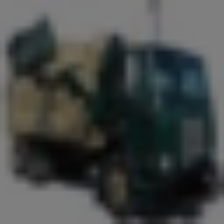
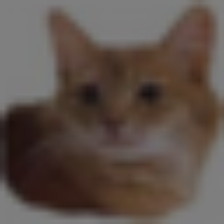
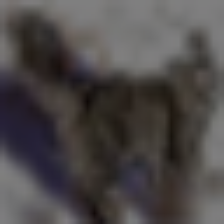
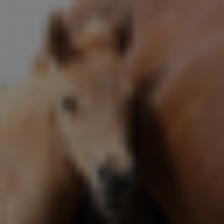
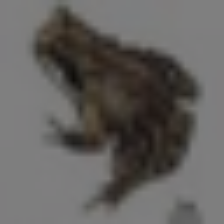
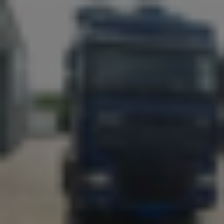
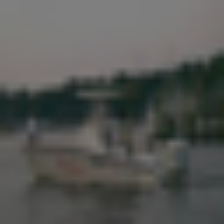
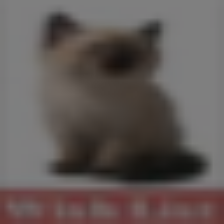
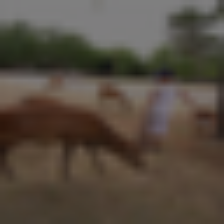
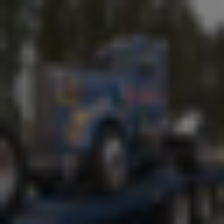
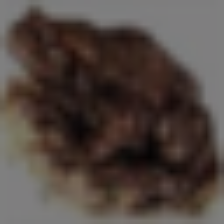
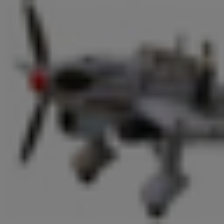
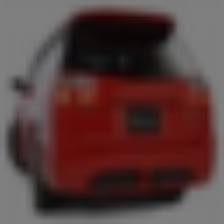
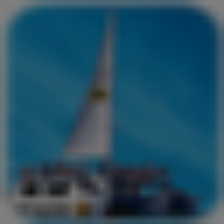
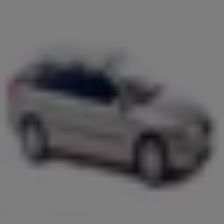
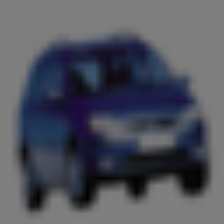
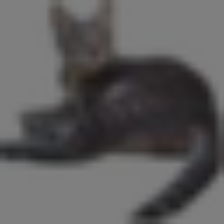
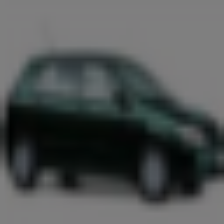
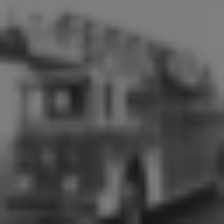
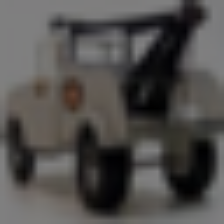

In [174]:
show.blocks([
    ['unit %d' % u,
     'img %d' % i,
     'pred: %s' % dataset_imgs[i][1],
     [iv.masked_image(
        dataset_imgs[i][0],
        model.retained_layer(layername)[0],
        u)]
    ]
    for u in [2]
    for i in top_indexes[u, :20]
])